In [176]:
# !pip install pingouin

In [177]:
# !pip install scikit-posthocs

In [178]:
# !pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import pearsonr, bartlett, levene, wilcoxon, mannwhitneyu, ttest_ind, f_oneway, kruskal
from scipy.stats import shapiro, anderson, kstest, normaltest, jarque_bera
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [3]:
df = pd.read_csv(r'C:\Users\User\Desktop\DigitalHana_Project2\Data\HanaCard_Data.csv', encoding = 'cp949')

In [4]:
df2 = df.copy()

In [5]:
d = {
    '21.Active_연속' : 0,
    '22.Active_간헐' : 1,
    '34.휴면_9M+' : 2,
    '32.휴면_6M-' : 2,
    '33.휴면_9M-' : 2,
    '31.휴면_3M' : 2
}
df2['고객구분'] = df2['고객구분'].map(d)

In [6]:
df2['Recency'] = (df[['이용후경과월_신용','이용후경과월_체크', '이용후경과월_카드론']]).min(axis= 1)

In [23]:
df2['Recency'].value_counts().sort_index()

0     243637
1       8549
2       5339
3       4252
4       3121
5       2768
6       2468
7       2273
8       1903
9       1721
10      1644
11      1539
12     20786
Name: Recency, dtype: int64

In [24]:
df2.loc[df2['Recency'].isin(range(2, 12)), 'Recency'].value_counts().sort_index().values

array([5339, 4252, 3121, 2768, 2468, 2273, 1903, 1721, 1644, 1539],
      dtype=int64)

In [25]:
import itertools
val = [5339, 4252, 3121, 2768, 2468, 2273, 1903, 1721, 1644, 1539]
res = []

for case in filter(lambda x : sum(x) == 10, itertools.product(range(1, 7), repeat = 5)):
    res.append((case, pd.Series([sum(val[:case[0]]), sum(val[case[0]:sum(case[:1])]), sum(val[sum(case[:1]):sum(case[:2])]), sum(val[sum(case[:2]):sum(case[:3])]), sum(val[sum(case[:3]):])]).std()))

sorted(res, key = lambda x : x[1])[:10]

[((1, 2, 3, 1, 3), 3141.8077280444772),
 ((1, 2, 3, 2, 2), 3141.8077280444772),
 ((1, 2, 3, 3, 1), 3141.8077280444772),
 ((1, 2, 2, 1, 4), 3414.1466430134483),
 ((1, 2, 2, 2, 3), 3414.1466430134483),
 ((1, 2, 2, 3, 2), 3414.1466430134483),
 ((1, 2, 2, 4, 1), 3414.1466430134483),
 ((2, 2, 3, 1, 2), 3491.310541902568),
 ((2, 2, 3, 2, 1), 3491.310541902568),
 ((2, 2, 2, 1, 3), 3513.4518354461616)]

In [19]:
df2['Recency'].value_counts().sort_index().values

array([243637,   8549,   5339,   4252,   3121,   2768,   2468,   2273,
         1903,   1721,   1644,   1539,  20786], dtype=int64)

In [16]:
import itertools
val = [243637,   8549,   5339,   4252,   3121,   2768,   2468,   2273, 1903,   1721,   1644,   1539,  20786]
res = []

for case in filter(lambda x : sum(x) == 13, itertools.product(range(1, 7), repeat = 8)):
    res.append((case, pd.Series([sum(val[:case[0]]), sum(val[case[0]:sum(case[:1])]), sum(val[sum(case[:1]):sum(case[:2])]), sum(val[sum(case[:2]):sum(case[:3])]), sum(val[sum(case[:3]):sum(case[:4])]), sum(val[sum(case[:4]):sum(case[:5])]), sum(val[sum(case[:5]):sum(case[:6])]), sum(val[sum(case[:6]):])]).std()))

sorted(res, key = lambda x : x[1])[:10]

[((1, 1, 1, 2, 3, 3, 1, 1), 83535.69104623143),
 ((1, 1, 1, 2, 2, 4, 1, 1), 83535.81543437351),
 ((1, 1, 1, 1, 3, 4, 1, 1), 83541.06718939409),
 ((1, 1, 2, 2, 2, 3, 1, 1), 83544.15026285716),
 ((1, 1, 1, 1, 2, 5, 1, 1), 83548.03889465543),
 ((1, 1, 1, 3, 2, 3, 1, 1), 83548.14907926702),
 ((1, 1, 2, 2, 3, 2, 1, 1), 83548.62772062747),
 ((1, 1, 1, 2, 4, 2, 1, 1), 83549.17612144016),
 ((1, 1, 2, 1, 3, 3, 1, 1), 83551.8176445868),
 ((1, 1, 2, 1, 2, 4, 1, 1), 83551.94200872038)]

In [189]:
df2['Recency_8'] = df2['Recency'].map(lambda x : dict(zip(range(13), [8, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 2, 1]))[x])

In [190]:
df2['Frequency'] = df2['이용건수_신용_R12M'] + df2['이용건수_체크_R12M'] + df2['이용건수_카드론_R12M']

In [191]:
df2['Frequency_8'] = pd.cut(df2['Frequency'], bins = [df2['Frequency'].quantile(0), df2['Frequency'].quantile(0.125), df2['Frequency'].quantile(0.25), df2['Frequency'].quantile(0.375), df2['Frequency'].quantile(0.5), df2['Frequency'].quantile(0.625), df2['Frequency'].quantile(0.75), df2['Frequency'].quantile(0.875), df2['Frequency'].quantile(1)], labels = range(1, 9), include_lowest = True).astype(np.int64)

In [192]:
df2['Monetary'] = df2['이용금액_신용_R12M'] + df2['이용금액_체크_R12M'] + df2['이용금액_카드론_R12M'] + df2['이용금액_업종기준']

In [193]:
df2['Monetary_8'] = pd.cut(df2['Monetary'], bins = [df2['Monetary'].quantile(0), df2['Monetary'].quantile(0.125), df2['Monetary'].quantile(0.25), df2['Monetary'].quantile(0.375), df2['Monetary'].quantile(0.5), df2['Monetary'].quantile(0.625), df2['Monetary'].quantile(0.75), df2['Monetary'].quantile(0.875), df2['Monetary'].quantile(1)], labels = range(1, 9), include_lowest = True).astype(np.int64)

# RFM 8개 값 분류

In [194]:
scaler = MinMaxScaler()
df2['Recency_s'] = scaler.fit_transform(df2[['Recency']])
df2['Frequency_s'] = scaler.fit_transform(df2[['Frequency']])
df2['Monetary_s'] = scaler.fit_transform(df2[['Monetary']])

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_k

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

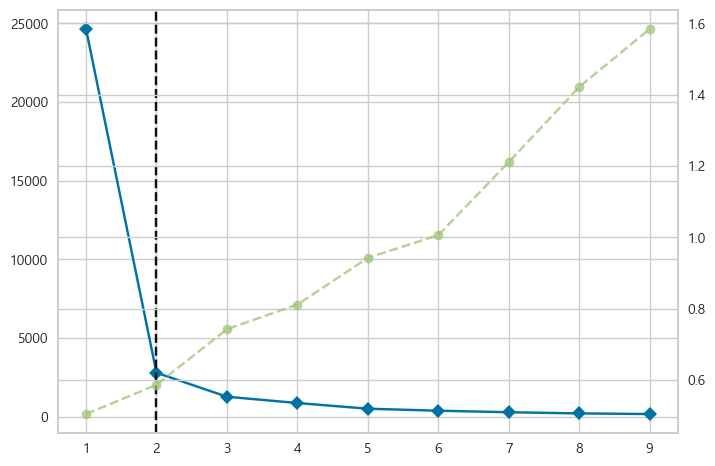

In [195]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df2[['Recency_s','Frequency_s','Monetary_s']])
# k = 2

In [196]:
# KMeans 모델 생성 (k=2)
kmeans = KMeans(n_clusters=2)
# 모델 학습 및 예측
labels = kmeans.fit_predict(df2[['Recency_s','Frequency_s','Monetary_s']])

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [197]:
df2['labels_k'] = labels

In [198]:
# CV = k개 그룹에 대한 각 R,F,M의 표준편차 / 평균
cv_k = df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('std') / df2.groupby('labels_k')[['Recency_s', 'Frequency_s', 'Monetary_s']].agg('mean')
cv_k

,Recency_s,Frequency_s,Monetary_s
labels_k,,,
0,3.707733,1.040649,1.242323
1,0.195777,1.055173,0.395543


In [199]:
res = cv_k.min(axis = 0) / cv_k.sum()
res

Recency_s      0.050154
Frequency_s    0.496535
Monetary_s     0.241499
dtype: float64

In [200]:
# 가중치
w1, w2, w3 = (res / res.sum())
print(w1, w2, w3)

0.0636321049561043 0.629970431576547 0.30639746346734875


In [201]:
df2['RFM_Score'] = ((w1 * df2['Recency_8'] + w2 * df2['Frequency_8'] + w3 * df2['Monetary_8']) / 8) * 100

In [203]:
df2['RFM_Class'] = pd.cut(df2['RFM_Score'], bins = [df2['RFM_Score'].quantile(0), df2['RFM_Score'].quantile(0.125), df2['RFM_Score'].quantile(0.25), df2['RFM_Score'].quantile(0.375), df2['RFM_Score'].quantile(0.5), df2['RFM_Score'].quantile(0.625), df2['RFM_Score'].quantile(0.75), df2['RFM_Score'].quantile(0.875), df2['RFM_Score'].quantile(1)], labels = ['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], include_lowest = True).astype(np.dtype('O'))
df2['RFM_Class'].value_counts()

이탈우려고객     44549
잠재VIP고객    41394
겨울잠고객      38024
잠재충성고객     37120
관심필요고객     36905
충성고객       35952
VIP고객      33888
놓치면안될고객    32168
Name: RFM_Class, dtype: int64

In [204]:
for rfm, customer_group in sorted(df2.groupby(by = ['RFM_Class'])[['고객구분']], key = lambda x : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[x[0]]):
    print(rfm)
    print(customer_group['고객구분'].value_counts())
    print()

VIP고객
0    33121
1      540
2      227
Name: 고객구분, dtype: int64

충성고객
0    34469
1     1038
2      445
Name: 고객구분, dtype: int64

잠재VIP고객
0    38619
1     1805
2      970
Name: 고객구분, dtype: int64

잠재충성고객
0    33689
1     2129
2     1302
Name: 고객구분, dtype: int64

놓치면안될고객
0    26534
1     3544
2     2090
Name: 고객구분, dtype: int64

관심필요고객
0    26307
1     6563
2     4035
Name: 고객구분, dtype: int64

이탈우려고객
0    28217
1     9252
2     7080
Name: 고객구분, dtype: int64

겨울잠고객
2    31953
1     4164
0     1907
Name: 고객구분, dtype: int64



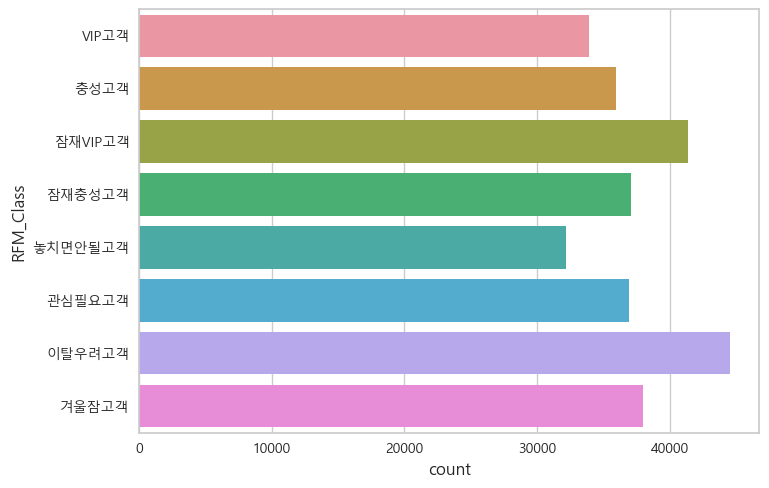

In [205]:
sns.countplot(y = 'RFM_Class', data = df2, orient = 'h', order = reversed(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객', '잠재충성고객','잠재VIP고객','충성고객','VIP고객']))
plt.show()

In [206]:
# RFM_Class 그룹에 따른 R, F, M들의 평균값/중위값 차이가 있는지 분산분석
for column in ['Recency', 'Frequency', 'Monetary']:
  normally = []
  for cla in df2['RFM_Class'].unique():
    # 1. 정규성 검정
    # shapiro나 kolmogorov-smirnov 같은 검정방법은 데이터의 갯수에 따라 달라지므로 데이터 갯수에 상관없이 하기 위해 normaltest로 검정
    cla_tv, cla_pv = normaltest(df2.loc[df2['RFM_Class'] == cla, column])
    if cla_pv >= 0.05:
      normally.append(True)
    else:
      normally.append(False)

  # 정규성인지 아닌지에 따라 등분산분석 할지 정하기
  if all(normally):
    # 2. 등분산분석
    bartlett_tv, bartlett_pv = bartlett(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
    # 등분산이므로 F검정으로 일원분산분석
    if bartlett_pv >= 0.05:
      f_oneway_tv, f_oneway_pv = f_oneway(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
      if f_oneway_pv < 0.05:
        print(f'column : {column},     f_oneway : {f_oneway_pv}')
    # 등분산이 아니므로 Welch_Anova로 일원분산분석
    else:
      welch_anova_tv, welch_anova_pv = pg.welch_anova(dv = column, between = 'RFM_Class', data = df2)
      if welch_anova_pv < 0.05:
        print(f'column : {column},     welch_anova_pv : {welch_anova_pv}')
  # 정규성을 만족하지 않으므로 Kruskal-Wallis H-test로 일원분산분석
  else:
    kruskal_tv, kruskal_pv = kruskal(*[df2.loc[df2['RFM_Class'] == cla, column] for cla in df2['RFM_Class'].unique()])
    if kruskal_pv < 0.05:
      print(f'column : {column},     kruskal_pv : {kruskal_pv}')

column : Recency,     kruskal_pv : 0.0
column : Frequency,     kruskal_pv : 0.0
column : Monetary,     kruskal_pv : 0.0


In [207]:
df2.groupby(by = ['RFM_Class'])[['Recency', 'Frequency', 'Monetary']].agg('median').sort_index(key = lambda x : x.map(lambda y : dict(zip(['겨울잠고객','이탈우려고객','관심필요고객','놓치면안될고객','잠재충성고객','잠재VIP고객','충성고객','VIP고객'], range(8, 0, -1)))[y]))

,Recency,Frequency,Monetary
RFM_Class,,,
VIP고객,0.0,832.0,24057959.0
충성고객,0.0,459.0,18082075.5
잠재VIP고객,0.0,296.0,10631577.5
잠재충성고객,0.0,186.0,6953348.5
놓치면안될고객,0.0,105.0,6332325.0
관심필요고객,0.0,57.0,2945200.0
이탈우려고객,0.0,17.0,645260.0
겨울잠고객,12.0,0.0,0.0
